# Introduction to using JUNE

This notebook aims to introduce users to the JUNE pipeline and demonstrate how:(1) a world and its demography can be constructed in JUNE, (2) the epidemiology in that world can be simulated, (3) how the results from a JUNE simulation can be processed. 

Prior to running this notebook be sure to clone the JUNE repository and run ```pip install -e .``` in the root of the repository.

### Import the relevant modules

In [83]:
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os

In [84]:
from june import World 
from june.geography import Geography
from june.demography import Demography
from june.interaction import Interaction
from june.epidemiology.epidemiology import Epidemiology
from june.epidemiology.infection import Infection, InfectionSelector, InfectionSelectors
from june.epidemiology.infection.health_index import Data2Rates
from june.epidemiology.infection.health_index.health_index import HealthIndexGenerator
from june.epidemiology.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries, Universities
from june.groups.leisure import generate_leisure_for_config, Cinemas, Pubs, Groceries, Gyms
from june.groups.travel import *
from june.simulator import Simulator
from june.epidemiology.infection_seed import InfectionSeed
from june.policy import Policy, Policies
from june import paths
from june.hdf5_savers import load_geography_from_hdf5
from june.records import Record, RecordReader

from june.world import generate_world_from_geography
from june.hdf5_savers import generate_world_from_hdf5

# Creating a World

Prior to any JUNE simulation we need to construct a World. By the term 'World' we refer to a digital twin of the demography, geography and Supergroups that we want to simulate. 

Geography is captured in Regions, SuperAreas and Areas (a schema which allows JUNE simulations to operate with different topological data at different levels of granularity). Areas are the smallest geographical unit comprised of a latitude and longitude. A SuperArea is a spatially contiguous set of Areas and a SuperArea is a spatially contiguous set of Regions. Demography is responsible for the population attributes (e.g. sex, age ethnicity). Finally, SuperGroups are added, bringing, for example, households, companies and schools into our World.

To initialize a certain world, we need to add the different components we want to have in it. First we specify what SuperAreas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies. After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [85]:
%%time 

geography = Geography.from_file(
{
    "super_area": ["E02001731", "E02002566"]})

geography.hospitals = Hospitals.for_geography(geography)
geography.schools = Schools.for_geography(geography)
geography.companies = Companies.for_geography(geography)
geography.care_homes = CareHomes.for_geography(geography)
geography.universities = Universities.for_geography(geography)
world = generate_world_from_geography(geography, include_households=True)


2021-09-21 11:56:48,783 - june.geography.geography - INFO - There are 67 areas and 2 super_areas and 1 regions in the world.
2021-09-21 11:56:48,788 - hospitals - INFO - There are 1 hospitals in this geography.
2021-09-21 11:56:48,812 - schools - INFO - There are 7 schools in this geography.
2021-09-21 11:56:48,818 - schools - INFO - No school for the age 0 in this world.
2021-09-21 11:56:48,821 - schools - INFO - No school for the age 1 in this world.
2021-09-21 11:56:48,840 - schools - INFO - No school for the age 12 in this world.
2021-09-21 11:56:48,842 - schools - INFO - No school for the age 13 in this world.
2021-09-21 11:56:48,985 - care_homes - INFO - There are 4 care_homes in this geography.
2021-09-21 11:56:49,007 - universities - INFO - There are 3 universities in this world.
2021-09-21 11:56:53,972 - world - INFO - Populating areas
2021-09-21 11:56:54,073 - world - INFO - Areas populated. This world's population is: 19199
2021-09-21 11:56:55,274 - worker_distributor - INFO

## Configuring JUNE

We also specify the path to a config file that is important to how a JUNE simulation proceeds. Run the cell below to view the file.

We define the activities that our SuperGroups can carry out - for example, going to hospital, school etc. Further, we introduce time into our world. The `step_duration` deserves to be elaborated upon. It specifies the duration of each time step by day type - i.e. both for weekdays and weekends. According to the schema below weekdays are specified to have five time steps; a weekday starts with a one hour time step (when people commute), then 8 hours and so on. A weekend day will have three time stps of four hours and one of 12 hours. Users can modify this to add more timesteps or change the duration of a time step - the only requirement is that the duration of a day type sums to 24.

In [86]:
CONFIG_PATH = paths.configs_path / "config_example.yaml"
os.environ["CONFIG_PATH"] = str(CONFIG_PATH)
!cat $CONFIG_PATH

title: Covid configuration example

activity_to_super_groups:
  medical_facility: ["hospitals"]
  primary_activity: ['schools', 'companies', "universities"]
  leisure: ['pubs', 'cinemas', 'groceries', 'gyms', "care_home_visits", "household_visits"] 
  residence: ['households', 'care_homes']
  commute: ['city_transports', 'inter_city_transports']

time:
  total_days: 30
  initial_day: "2020-03-01" 
  step_duration: 
      weekday:
          0: 1 
          1: 8
          2: 1
          3: 3
          4: 11
      weekend:
          0: 4 
          1: 4 
          2: 4 
          3: 12 
  step_activities:
      weekday:
          0: ['medical_facility', 'residence', 'commute'] 
          1: ['medical_facility', 'primary_activity', 'leisure', 'residence'] 
          2: ['medical_facility', 'residence', 'commute'] 
          3: ['medical_facility', 'leisure', 'residence']
          4: ['medical_facility', 'residence']
      weekend:
          0: ['medical_facility', 'leisure', 'residence']


## Commute, travel and leisure

Here we add further detail to our world. Specifically, we establish what our agents can do in their world.

In [87]:
%%time

world.pubs = Pubs.for_geography(geography)
world.cinemas = Cinemas.for_geography(geography)
world.groceries = Groceries.for_geography(geography)
world.gyms = Gyms.for_geography(geography)
leisure = generate_leisure_for_config(world, config_filename=CONFIG_PATH)
leisure.distribute_social_venues_to_areas(
    areas=world.areas, super_areas=world.super_areas
)


2021-09-21 11:56:58,817 - social_venue - INFO - Domain 0 has 2963 pubs(s)
2021-09-21 11:56:58,830 - social_venue - INFO - Domain 0 has 14 cinemas(s)
2021-09-21 11:56:59,003 - social_venue - INFO - Domain 0 has 834 groceries(s)
2021-09-21 11:56:59,051 - social_venue - INFO - Domain 0 has 174 gyms(s)
2021-09-21 11:56:59,101 - leisure - INFO - Linking households and care homes for visits
2021-09-21 11:56:59,135 - leisure - INFO - Done
2021-09-21 11:56:59,135 - leisure - INFO - Distributing social venues to areas
2021-09-21 11:56:59,136 - leisure - INFO - Distributed in 0 of 67 areas.
2021-09-21 11:56:59,181 - leisure - INFO - Distributed in 67 of 67 areas.
CPU times: user 1.01 s, sys: 6.39 ms, total: 1.01 s
Wall time: 1.01 s


Now we know where everyone works in our world, we can deduce the commutes that our agents would make - for example, when going into work. This is important to the way JUNE models the spread of a disease through a population.

In [88]:
travel = Travel()
travel.initialise_commute(world)

2021-09-21 11:56:59,188 - travel - INFO - Initialising commute...
2021-09-21 11:56:59,190 - travel - INFO - Creating cities...
2021-09-21 11:56:59,196 - travel - INFO - This world has 2 cities, with names
['Newcastle upon Tyne', 'Darlington']
2021-09-21 11:56:59,197 - travel - INFO - Determining people mode of transport
2021-09-21 11:57:04,125 - travel - INFO - Mode of transport allocated in 0 of 67 areas.
2021-09-21 11:57:04,145 - travel - INFO - Mode of transport determined for everyone.
2021-09-21 11:57:04,268 - travel - INFO - Assigning commuters to stations...
2021-09-21 11:57:04,269 - travel - INFO - Assigned 0 of 19199 potential commuters...
2021-09-21 11:57:04,273 - travel - INFO - Commuters assigned
2021-09-21 11:57:04,274 - travel - INFO - City Newcastle upon Tyne has 894 internal and 184 external commuters.
2021-09-21 11:57:04,277 - travel - INFO - Creating stations...
2021-09-21 11:57:04,279 - travel - INFO - City Newcastle upon Tyne has 1 city and 4 inter city stations.
20

Finally, we are also going to need some cemeteries...


In [89]:
world.cemeteries = Cemeteries()

## How to 'save the world'

If it took a long time to run the previous commands, it might be a good idea to save the world to reuse it later. Here we write the state of our World object to a file called `world.hdf5`

In [90]:
world.to_hdf5("world.hdf5")

2021-09-21 11:57:04,296 - world_saver - INFO - saving world to HDF5
2021-09-21 11:57:04,309 - world_saver - INFO - saving population...
2021-09-21 11:57:04,665 - world_saver - INFO - saving hospitals...
2021-09-21 11:57:04,669 - world_saver - INFO - saving schools...
2021-09-21 11:57:04,674 - world_saver - INFO - saving companies...
2021-09-21 11:57:04,678 - world_saver - INFO - saving households...
2021-09-21 11:57:04,815 - world_saver - INFO - saving care homes...
2021-09-21 11:57:04,819 - world_saver - INFO - saving cities...
2021-09-21 11:57:04,823 - world_saver - INFO - saving stations...
2021-09-21 11:57:04,825 - world_saver - INFO - saving universities...
2021-09-21 11:57:04,828 - world_saver - INFO - saving social venues...
2021-09-21 11:57:04,840 - world_saver - INFO - Saving domain decomposition data...


If we would like to load the world we saved, we just do:

In [91]:
world = generate_world_from_hdf5("world.hdf5")

2021-09-21 11:57:04,846 - world_saver - INFO - loading world from HDF5
2021-09-21 11:57:04,852 - world_saver - INFO - loading hospitals...
2021-09-21 11:57:04,856 - world_saver - INFO - loading schools...
2021-09-21 11:57:04,859 - company_saver - INFO - loading companies...
2021-09-21 11:57:04,860 - company_saver - INFO - Companies chunk 0 of 1
2021-09-21 11:57:04,872 - world_saver - INFO - loading care homes...
2021-09-21 11:57:04,875 - world_saver - INFO - loading universities...
2021-09-21 11:57:04,877 - world_saver - INFO - loading cities...
2021-09-21 11:57:04,881 - world_saver - INFO - loading stations...
2021-09-21 11:57:04,884 - household_saver - INFO - loading households...
2021-09-21 11:57:04,886 - household_saver - INFO - Loaded chunk 0 of 1
2021-09-21 11:57:04,945 - population saver - INFO - loading population...
2021-09-21 11:57:04,946 - population saver - INFO - Loaded chunk 0 of 1
2021-09-21 11:57:05,022 - world_saver - INFO - loading social venues...
2021-09-21 11:57:05

Note: if we load the world from a file we have to regenerate the leisure object that draws on information in the world:

In [92]:
leisure = generate_leisure_for_config(world, CONFIG_PATH)

Similarly, a travel object must also be redefined:

In [93]:
travel = Travel()

You have now a beautiful pre-pandemic world. 

# Adding the infection

The module in charge of infecting people is called the ``InfectionSelector``, which gives people a transmission time profile and a symptoms trajectory based on their age and sex (through the health index generator)

In [94]:
selector = InfectionSelector.from_file()
selectors = InfectionSelectors([selector])

All the functionality related to infections is handled by the Epidemiology class.

In [95]:
epidemiology = Epidemiology(infection_selectors=selectors)

# Adding the interaction

June models human-to-human transmissible diseases. The model, therefore, needs information about the interactions between its agents. We read this out of a config file: `june/configs/defaults/interaction/interaction.yaml`

In [96]:
interaction = Interaction.from_file()

Betas are the intensities of the interaction taking place at the different groups

In [97]:
interaction.betas

{'box': 1,
 'pub': 0.42941,
 'gym': 0.42941,
 'grocery': 0.04137,
 'cinema': 0.157461,
 'city_transport': 0.107969,
 'inter_city_transport': 0.383,
 'hospital': 0.1168,
 'care_home': 0.28,
 'company': 0.371,
 'school': 0.07,
 'household': 0.208,
 'household_visits': 0.208,
 'care_visits': 0.208,
 'university': 0.306}

Moreover, this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [98]:
interaction.alpha_physical

2.0

# Seed the disease

There are two options implemented in the seed at the moment, either you specify the number of cases and these are then homogeneously distributed by population to the different areas, or you use UK data on cases per region. For now use the first case.

In [99]:
infection_seed = InfectionSeed(
    world, selector,
)

In [100]:
n_cases = 50
infection_seed.unleash_virus(
    population=world.people,
    n_cases=n_cases, # play around with the initial number of cases
    time=0
)

# Set policies

JUNE's policy layer allows users to experiment with policy measures designed to control and redice the impact of human to human transmissible diseases. These might include social distancing measures, the closure of schools or restaurants and much more. Since JUNE has highly granular layers of geographical knowledge, policies can be tested on regional levels or even in relation to specific individuals and venues.

Here we load in the set of policies captured in `june/configs/defaults/policy/policy.yaml`

In [101]:
policies = Policies.from_file()

We can have a look at one of the policies

In [102]:
print(policies.individual_policies[8].__dict__)

{'spec': 'close_companies', 'start_time': datetime.datetime(2020, 3, 16, 0, 0), 'end_time': datetime.datetime(2020, 3, 20, 0, 0), 'policy_type': 'individual', 'policy_subtype': 'skip_activity', 'activities_to_remove': ['primary_activity', 'commute'], 'full_closure': False, 'avoid_work_probability': 0.2, 'furlough_probability': 0.04, 'key_probability': 0.22}


# Run the simulation

The first thing we need is a place to save our simulation results. For that we can use the record class, and pass it to the simulator.

In [103]:
record = Record(    
    record_path = 'results',    
    record_static_data=True,
) 

The simulator is the main module in charge of running the simulation. It coordinates the ``ActivityManager`` which is responsible of allocating people to the right groups given the current timestep, it updates the health status of the population, and it runs the interaction over the different groups. All of these modules can be modified by policies at any given time.

Since the timer configuration is a bit cumbersome, it is read from the config file at https://github.com/IDAS-Durham/JUNE/blob/master/june/configs/config_example.yaml

In [104]:
simulator = Simulator.from_file(
    world=world,
    epidemiology=epidemiology,
    interaction=interaction, 
    config_filename = CONFIG_PATH,
    leisure = leisure,
    travel = travel,
    record=record,
    policies = policies
)

In [105]:
%%time
simulator.run()

2021-09-21 11:57:05,941 - simulator - INFO - Starting simulation for 30 days at day 2020-03-01 00:00:00,to run for 30 days
2021-09-21 11:57:06,104 - rank - INFO - Next timestep
2021-09-21 11:57:06,105 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:06,269 - rank - INFO - Rank 0 -- move_people -- 0.16351325700816233
2021-09-21 11:57:06,270 - rank - INFO - Rank 0 -- move_people_waiting -- 3.3140095183625817e-06
2021-09-21 11:57:06,270 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5590125005692244e-06,2.384185791015625e-06 - 2020-03-01 00:00:00
2021-09-21 11:57:06,274 - simulator - INFO - Info for rank 0, Date = 2020-03-01 00:00:00, number of deaths =  0, number of infected = 50
2021-09-21 11:57:06,343 - rank - INFO - Rank 0 -- interaction -- 0.07215819400153123
2021-09-21 11:57:06,345 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000318389997119084,0.00031876564025878906 - 2020-03-01 00:00:00
2021-09-21 11:57:06,3

2021-09-21 11:57:07,721 - simulator - INFO - Info for rank 0, Date = 2020-03-02 10:00:00, number of deaths =  0, number of infected = 55
2021-09-21 11:57:07,779 - rank - INFO - Rank 0 -- interaction -- 0.05925375799415633
2021-09-21 11:57:07,780 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002493409992894158,0.0002493858337402344 - 2020-03-02 10:00:00
2021-09-21 11:57:07,798 - rank - INFO - Rank 0 -- interaction_waiting -- 3.349006874486804e-06
2021-09-21 11:57:07,811 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012584839001647197,0.012584924697875977 - 2020-03-02 10:00:00

2021-09-21 11:57:07,812 - rank - INFO - Next timestep
2021-09-21 11:57:07,812 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:07,855 - rank - INFO - Rank 0 -- move_people -- 0.041728929994860664
2021-09-21 11:57:07,855 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6589917726814747e-06
2021-09-21 11:57:07,856 - activity_manager - INFO - CMS: Peo

2021-09-21 11:57:09,053 - rank - INFO - Next timestep
2021-09-21 11:57:09,054 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:09,113 - rank - INFO - Rank 0 -- move_people -- 0.05888160200265702
2021-09-21 11:57:09,114 - rank - INFO - Rank 0 -- move_people_waiting -- 4.83199255540967e-06
2021-09-21 11:57:09,114 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.3529940992593765e-06,3.0994415283203125e-06 - 2020-03-04 01:00:00
2021-09-21 11:57:09,116 - simulator - INFO - Info for rank 0, Date = 2020-03-04 01:00:00, number of deaths =  0, number of infected = 66
2021-09-21 11:57:09,219 - rank - INFO - Rank 0 -- interaction -- 0.10459397500380874
2021-09-21 11:57:09,222 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018573699344415218,0.0001857280731201172 - 2020-03-04 01:00:00
2021-09-21 11:57:09,242 - rank - INFO - Rank 0 -- interaction_waiting -- 3.5519915400072932e-06
2021-09-21 11:57:09,254 - simulator - INFO - CMS

2021-09-21 11:57:10,613 - rank - INFO - Rank 0 -- interaction -- 0.06782012400799431
2021-09-21 11:57:10,615 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002927089954027906,0.0002923011779785156 - 2020-03-05 10:00:00
2021-09-21 11:57:10,635 - rank - INFO - Rank 0 -- interaction_waiting -- 3.7449935916811228e-06
2021-09-21 11:57:10,648 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01284960299381055,0.012849807739257812 - 2020-03-05 10:00:00

2021-09-21 11:57:10,648 - rank - INFO - Next timestep
2021-09-21 11:57:10,649 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:10,695 - rank - INFO - Rank 0 -- move_people -- 0.045292383001651615
2021-09-21 11:57:10,696 - rank - INFO - Rank 0 -- move_people_waiting -- 3.975990694016218e-06
2021-09-21 11:57:10,696 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8899958124384284e-06,2.384185791015625e-06 - 2020-03-05 13:00:00
2021-09-21 11:57:10,698 - simulator - INFO - In

2021-09-21 11:57:12,352 - rank - INFO - Rank 0 -- move_people -- 0.15417450800305232
2021-09-21 11:57:12,353 - rank - INFO - Rank 0 -- move_people_waiting -- 5.006004357710481e-06
2021-09-21 11:57:12,353 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.663000486791134e-06,2.1457672119140625e-06 - 2020-03-07 04:00:00
2021-09-21 11:57:12,355 - simulator - INFO - Info for rank 0, Date = 2020-03-07 04:00:00, number of deaths =  0, number of infected = 102
2021-09-21 11:57:12,416 - rank - INFO - Rank 0 -- interaction -- 0.06256250500155147
2021-09-21 11:57:12,417 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000173937005456537,0.00017380714416503906 - 2020-03-07 04:00:00
2021-09-21 11:57:12,436 - rank - INFO - Rank 0 -- interaction_waiting -- 2.1877989638596773e-05
2021-09-21 11:57:12,447 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011143744995933957,0.011125564575195312 - 2020-03-07 04:00:00

2021-09-21 11:57:12,448 - rank - INFO - Next timestep
2021-

2021-09-21 11:57:13,879 - rank - INFO - Rank 0 -- interaction_waiting -- 5.9710000641644e-06
2021-09-21 11:57:13,893 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013287200999911875,0.013288021087646484 - 2020-03-09 00:00:00

2021-09-21 11:57:13,894 - rank - INFO - Next timestep
2021-09-21 11:57:13,894 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:13,958 - rank - INFO - Rank 0 -- move_people -- 0.06279404999804683
2021-09-21 11:57:13,959 - rank - INFO - Rank 0 -- move_people_waiting -- 5.189998773857951e-06
2021-09-21 11:57:13,959 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8139911592006683e-06,2.384185791015625e-06 - 2020-03-09 01:00:00
2021-09-21 11:57:13,963 - simulator - INFO - Info for rank 0, Date = 2020-03-09 01:00:00, number of deaths =  0, number of infected = 115
2021-09-21 11:57:14,083 - rank - INFO - Rank 0 -- interaction -- 0.12289400299778208
2021-09-21 11:57:14,090 - epidemiology - INFO - CMS: Infection C

2021-09-21 11:57:15,435 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.2909953258931637e-06,1.9073486328125e-06 - 2020-03-10 10:00:00
2021-09-21 11:57:15,437 - simulator - INFO - Info for rank 0, Date = 2020-03-10 10:00:00, number of deaths =  0, number of infected = 165
2021-09-21 11:57:15,505 - rank - INFO - Rank 0 -- interaction -- 0.06975383099052124
2021-09-21 11:57:15,506 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00015048800560180098,0.00015020370483398438 - 2020-03-10 10:00:00
2021-09-21 11:57:15,525 - rank - INFO - Rank 0 -- interaction_waiting -- 4.236993845552206e-06
2021-09-21 11:57:15,537 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012134353994042613,0.012134790420532227 - 2020-03-10 10:00:00

2021-09-21 11:57:15,538 - rank - INFO - Next timestep
2021-09-21 11:57:15,538 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:15,579 - rank - INFO - Rank 0 -- move_people -- 0.03982879800605588
2021-

2021-09-21 11:57:16,792 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012979049002751708,0.012979269027709961 - 2020-03-12 00:00:00

2021-09-21 11:57:16,793 - rank - INFO - Next timestep
2021-09-21 11:57:16,793 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:16,852 - rank - INFO - Rank 0 -- move_people -- 0.05819043300289195
2021-09-21 11:57:16,853 - rank - INFO - Rank 0 -- move_people_waiting -- 3.688997821882367e-06
2021-09-21 11:57:16,853 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.3740070648491383e-06,3.0994415283203125e-06 - 2020-03-12 01:00:00
2021-09-21 11:57:16,856 - simulator - INFO - Info for rank 0, Date = 2020-03-12 01:00:00, number of deaths =  0, number of infected = 204
2021-09-21 11:57:16,984 - rank - INFO - Rank 0 -- interaction -- 0.13028334100090433
2021-09-21 11:57:16,990 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018655600433703512,0.00018644332885742188 - 2020-03-12 01:00:00
20

2021-09-21 11:57:18,401 - simulator - INFO - Info for rank 0, Date = 2020-03-13 10:00:00, number of deaths =  0, number of infected = 264
2021-09-21 11:57:18,477 - rank - INFO - Rank 0 -- interaction -- 0.07764205599960405
2021-09-21 11:57:18,479 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00024825800210237503,0.000247955322265625 - 2020-03-13 10:00:00
2021-09-21 11:57:18,499 - rank - INFO - Rank 0 -- interaction_waiting -- 4.7679932322353125e-06
2021-09-21 11:57:18,513 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013190842990297824,0.013190984725952148 - 2020-03-13 10:00:00

2021-09-21 11:57:18,513 - rank - INFO - Next timestep
2021-09-21 11:57:18,514 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:18,558 - rank - INFO - Rank 0 -- move_people -- 0.04421834500681143
2021-09-21 11:57:18,559 - rank - INFO - Rank 0 -- move_people_waiting -- 4.645000444725156e-06
2021-09-21 11:57:18,559 - activity_manager - INFO - CMS: Peo

2021-09-21 11:57:20,118 - rank - INFO - Next timestep
2021-09-21 11:57:20,118 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:20,266 - rank - INFO - Rank 0 -- move_people -- 0.14744775200961158
2021-09-21 11:57:20,267 - rank - INFO - Rank 0 -- move_people_waiting -- 5.376990884542465e-06
2021-09-21 11:57:20,267 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.863002009689808e-06,2.6226043701171875e-06 - 2020-03-15 08:00:00
2021-09-21 11:57:20,270 - simulator - INFO - Info for rank 0, Date = 2020-03-15 08:00:00, number of deaths =  0, number of infected = 288
2021-09-21 11:57:20,348 - rank - INFO - Rank 0 -- interaction -- 0.07996458899287973
2021-09-21 11:57:20,349 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00025200699747074395,0.00025200843811035156 - 2020-03-15 08:00:00
2021-09-21 11:57:20,371 - rank - INFO - Rank 0 -- interaction_waiting -- 4.164990969002247e-06
2021-09-21 11:57:20,384 - simulator - INFO - CM

2021-09-21 11:57:22,292 - simulator - INFO - Info for rank 0, Date = 2020-03-17 00:00:00, number of deaths =  0, number of infected = 328
2021-09-21 11:57:22,358 - rank - INFO - Rank 0 -- interaction -- 0.06788321200292557
2021-09-21 11:57:22,359 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002620820014271885,0.0002620220184326172 - 2020-03-17 00:00:00
2021-09-21 11:57:22,380 - rank - INFO - Rank 0 -- interaction_waiting -- 4.18099807575345e-06
2021-09-21 11:57:22,392 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012529624000308104,0.012529611587524414 - 2020-03-17 00:00:00

2021-09-21 11:57:22,393 - rank - INFO - Next timestep
2021-09-21 11:57:22,393 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:22,548 - rank - INFO - Rank 0 -- move_people -- 0.15388781500223558
2021-09-21 11:57:22,548 - rank - INFO - Rank 0 -- move_people_waiting -- 4.70600207336247e-06
2021-09-21 11:57:22,548 - activity_manager - INFO - CMS: People

2021-09-21 11:57:24,429 - rank - INFO - Next timestep
2021-09-21 11:57:24,429 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:24,723 - rank - INFO - Rank 0 -- move_people -- 0.2928592709940858
2021-09-21 11:57:24,723 - rank - INFO - Rank 0 -- move_people_waiting -- 4.961999366059899e-06
2021-09-21 11:57:24,724 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.687011146917939e-06,1.9073486328125e-06 - 2020-03-18 10:00:00
2021-09-21 11:57:24,725 - simulator - INFO - Info for rank 0, Date = 2020-03-18 10:00:00, number of deaths =  0, number of infected = 358
2021-09-21 11:57:24,803 - rank - INFO - Rank 0 -- interaction -- 0.0795054420013912
2021-09-21 11:57:24,806 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00017143800505436957,0.00017118453979492188 - 2020-03-18 10:00:00
2021-09-21 11:57:24,825 - rank - INFO - Rank 0 -- interaction_waiting -- 4.062996595166624e-06
2021-09-21 11:57:24,839 - simulator - INFO - CMS: Ti

2021-09-21 11:57:26,751 - rank - INFO - Rank 0 -- interaction -- 0.06842568900901824
2021-09-21 11:57:26,751 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00017729500541463494,0.0001773834228515625 - 2020-03-20 00:00:00
2021-09-21 11:57:26,771 - rank - INFO - Rank 0 -- interaction_waiting -- 4.01500437874347e-06
2021-09-21 11:57:26,784 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013056260999292135,0.013056278228759766 - 2020-03-20 00:00:00

2021-09-21 11:57:26,785 - rank - INFO - Next timestep
2021-09-21 11:57:26,785 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:27,026 - rank - INFO - Rank 0 -- move_people -- 0.24028898499091156
2021-09-21 11:57:27,027 - rank - INFO - Rank 0 -- move_people_waiting -- 4.589994205161929e-06
2021-09-21 11:57:27,027 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.007997293025255e-06,2.86102294921875e-06 - 2020-03-20 01:00:00
2021-09-21 11:57:27,029 - simulator - INFO - Info 

2021-09-21 11:57:29,398 - rank - INFO - Rank 0 -- move_people -- 0.1451724080106942
2021-09-21 11:57:29,399 - rank - INFO - Rank 0 -- move_people_waiting -- 4.515008185990155e-06
2021-09-21 11:57:29,399 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.3759930627420545e-06,1.9073486328125e-06 - 2020-03-21 12:00:00
2021-09-21 11:57:29,401 - simulator - INFO - Info for rank 0, Date = 2020-03-21 12:00:00, number of deaths =  0, number of infected = 441
2021-09-21 11:57:29,468 - rank - INFO - Rank 0 -- interaction -- 0.06854853700497188
2021-09-21 11:57:29,471 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002244890056317672,0.00022411346435546875 - 2020-03-21 12:00:00
2021-09-21 11:57:29,491 - rank - INFO - Rank 0 -- interaction_waiting -- 3.769004251807928e-06
2021-09-21 11:57:29,504 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.013639801007229835,0.013640403747558594 - 2020-03-21 12:00:00

2021-09-21 11:57:29,505 - rank - INFO - Next timestep
2021-09-

2021-09-21 11:57:31,759 - rank - INFO - Rank 0 -- interaction_waiting -- 4.136993084102869e-06
2021-09-21 11:57:31,771 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012354973005130887,0.012355327606201172 - 2020-03-23 09:00:00

2021-09-21 11:57:31,772 - rank - INFO - Next timestep
2021-09-21 11:57:31,772 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:32,088 - rank - INFO - Rank 0 -- move_people -- 0.31519675900926813
2021-09-21 11:57:32,089 - rank - INFO - Rank 0 -- move_people_waiting -- 3.626992111094296e-06
2021-09-21 11:57:32,089 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.3750035325065255e-06,1.9073486328125e-06 - 2020-03-23 10:00:00
2021-09-21 11:57:32,091 - simulator - INFO - Info for rank 0, Date = 2020-03-23 10:00:00, number of deaths =  0, number of infected = 459
2021-09-21 11:57:32,174 - rank - INFO - Rank 0 -- interaction -- 0.0842782390100183
2021-09-21 11:57:32,175 - epidemiology - INFO - CMS: Infection CO

2021-09-21 11:57:34,355 - simulator - INFO - Info for rank 0, Date = 2020-03-25 00:00:00, number of deaths =  0, number of infected = 474
2021-09-21 11:57:34,437 - rank - INFO - Rank 0 -- interaction -- 0.08398906599904876
2021-09-21 11:57:34,439 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020678500004578382,0.0002067089080810547 - 2020-03-25 00:00:00
2021-09-21 11:57:34,463 - rank - INFO - Rank 0 -- interaction_waiting -- 4.752000677399337e-06
2021-09-21 11:57:34,477 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014099132007686421,0.014099836349487305 - 2020-03-25 00:00:00

2021-09-21 11:57:34,478 - rank - INFO - Next timestep
2021-09-21 11:57:34,478 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:34,714 - rank - INFO - Rank 0 -- move_people -- 0.23568370900466107
2021-09-21 11:57:34,715 - rank - INFO - Rank 0 -- move_people_waiting -- 4.60700539406389e-06
2021-09-21 11:57:34,715 - activity_manager - INFO - CMS: Peop

2021-09-21 11:57:37,171 - rank - INFO - Next timestep
2021-09-21 11:57:37,171 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:37,480 - rank - INFO - Rank 0 -- move_people -- 0.3085173900035443
2021-09-21 11:57:37,481 - rank - INFO - Rank 0 -- move_people_waiting -- 7.139999070204794e-06
2021-09-21 11:57:37,482 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.303990863263607e-06,4.0531158447265625e-06 - 2020-03-26 10:00:00
2021-09-21 11:57:37,486 - simulator - INFO - Info for rank 0, Date = 2020-03-26 10:00:00, number of deaths =  0, number of infected = 502
2021-09-21 11:57:37,596 - rank - INFO - Rank 0 -- interaction -- 0.11335811499156989
2021-09-21 11:57:37,598 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002183299948228523,0.0002181529998779297 - 2020-03-26 10:00:00
2021-09-21 11:57:37,628 - rank - INFO - Rank 0 -- interaction_waiting -- 5.207999492995441e-06
2021-09-21 11:57:37,647 - simulator - INFO - CMS: 

2021-09-21 11:57:40,229 - rank - INFO - Rank 0 -- interaction -- 0.09376868700201157
2021-09-21 11:57:40,231 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00024945600307546556,0.00024962425231933594 - 2020-03-28 00:00:00
2021-09-21 11:57:40,256 - rank - INFO - Rank 0 -- interaction_waiting -- 5.006004357710481e-06
2021-09-21 11:57:40,271 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015154075997998007,0.015154600143432617 - 2020-03-28 00:00:00

2021-09-21 11:57:40,271 - rank - INFO - Next timestep
2021-09-21 11:57:40,272 - simulator - INFO - ==================== timestep ====================
2021-09-21 11:57:40,523 - rank - INFO - Rank 0 -- move_people -- 0.25076987300417386
2021-09-21 11:57:40,524 - rank - INFO - Rank 0 -- move_people_waiting -- 5.221008905209601e-06
2021-09-21 11:57:40,524 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.05999128613621e-06,2.6226043701171875e-06 - 2020-03-28 04:00:00
2021-09-21 11:57:40,528 - simulator - INFO - In

2021-09-21 11:57:42,986 - rank - INFO - Rank 0 -- move_people -- 0.19843393100018147
2021-09-21 11:57:42,987 - rank - INFO - Rank 0 -- move_people_waiting -- 5.458990926854312e-06
2021-09-21 11:57:42,987 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.077002475038171e-06,2.86102294921875e-06 - 2020-03-30 00:00:00
2021-09-21 11:57:42,989 - simulator - INFO - Info for rank 0, Date = 2020-03-30 00:00:00, number of deaths =  0, number of infected = 524
2021-09-21 11:57:43,066 - rank - INFO - Rank 0 -- interaction -- 0.0785434110002825
2021-09-21 11:57:43,068 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020129700715187937,0.00020122528076171875 - 2020-03-30 00:00:00
2021-09-21 11:57:43,092 - rank - INFO - Rank 0 -- interaction_waiting -- 4.704997991211712e-06
2021-09-21 11:57:43,107 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.015171312988968566,0.01517176628112793 - 2020-03-30 00:00:00

2021-09-21 11:57:43,108 - rank - INFO - Next timestep
2021-09-

# Getting the results

The record saves a lot of information about the simulation, and it can be a bit overwhelming to look at everyting.
In the results folder (if you didn't change the path), we have a few extra contents:


In [106]:
!ls results

checkpoints  config.yaml  june_record.h5  policies.txt	summary.csv


Checkpoints would allow us to resume the simulation later, and the config and policies are there to remember what you used to run the code.
The ``summary.csv`` is useful to have a first glance at results:

In [107]:
summary = pd.read_csv("results/summary.csv", index_col=0)
summary.head()

,region,current_infected,daily_infected,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,
2020-03-01,North East,50,0,0,0,0,0,0,0
2020-03-01,North East,50,0,0,0,0,0,0,0
2020-03-01,North East,50,0,0,0,0,0,0,0
2020-03-01,North East,50,0,0,0,0,0,0,0
2020-03-02,North East,50,0,0,0,0,0,0,0


<AxesSubplot:xlabel='time_stamp'>

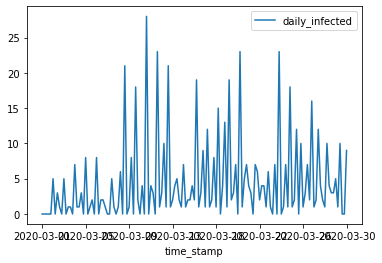

In [108]:
summary.plot(y="daily_infected")

If we want to get the full details, we can read the record:

In [109]:
read = RecordReader("./results")

In [110]:
read.regional_summary.head(3) # this is the equivalent of the summary.csv

,region,current_infected,daily_infected,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,
2020-03-01,North East,50.0,0,0.0,0,0.0,0,0,0
2020-03-02,North East,55.4,9,0.0,0,0.0,0,0,0
2020-03-03,North East,63.6,7,0.0,0,0.0,0,0,0


# Asking questions to the records

## Useful infections and death tables

In [111]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2021-09-21 11:57:44,956 - june.records.records_reader - INFO - Loading infections table
2021-09-21 11:57:44,965 - june.records.records_reader - INFO - Loading population table
2021-09-21 11:57:45,007 - june.records.records_reader - INFO - Merging infection and population tables
2021-09-21 11:57:45,011 - june.records.records_reader - INFO - Loading geography table
2021-09-21 11:57:45,032 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [112]:
infections_df.head(10)

,timestamp,location_ids,infector_ids,infection_ids,location_specs,region_names,age,primary_activity_id,residence_id,area_id,sex,ethnicity,primary_activity_type,residence_type,super_area_id,name_area,region_id,name_super_area,name_region
57526,2020-03-02,7532,46788,170852960,company,North East,30,7532,45594,334,m,A1,company,household,8,E00175587,4,E02001731,North East
57477,2020-03-04,12,44922,170852960,university,North East,24,12,45555,334,m,C5,university,household,8,E00175587,4,E02001731,North East
57541,2020-03-09,38640,43512,170852960,household,North East,38,8821,45563,334,m,A1,company,household,8,E00175587,4,E02001731,North East
57457,2020-03-10,45555,57477,170852960,household,North East,21,12,45555,334,m,C4,university,household,8,E00175587,4,E02001731,North East
57559,2020-03-10,45563,57541,170852960,household,North East,64,8349,45563,334,f,A1,company,household,8,E00175587,4,E02001731,North East
57241,2020-03-02,8294,56225,170852960,company,North East,60,8294,45325,332,m,A1,company,household,8,E00175576,4,E02001731,North East
57117,2020-03-09,12,56701,170852960,university,North East,22,12,45412,332,m,C4,university,household,8,E00175576,4,E02001731,North East
57120,2020-03-16,12,40010,170852960,university,North East,22,12,45382,332,f,D2,university,household,8,E00175576,4,E02001731,North East
57085,2020-03-19,12,46085,170852960,university,North East,19,12,45358,332,m,E1,university,household,8,E00175576,4,E02001731,North East
57156,2020-03-24,8007,52081,170852960,company,North East,25,8007,45420,332,f,D1,company,household,8,E00175576,4,E02001731,North East


In [113]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2021-09-21 11:57:45,065 - june.records.records_reader - INFO - Loading deaths table
2021-09-21 11:57:45,071 - june.records.records_reader - INFO - Loading population table
2021-09-21 11:57:45,110 - june.records.records_reader - INFO - Merging infection and population tables
2021-09-21 11:57:45,114 - june.records.records_reader - INFO - Loading geography table
2021-09-21 11:57:45,137 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [114]:
deaths_df.head(10)

,timestamp,location_ids,location_specs,age,primary_activity_id,residence_id,area_id,sex,ethnicity,primary_activity_type,residence_type,super_area_id,name_area,region_id,name_super_area,name_region
id,,,,,,,,,,,,,,,,


## Sero-prevalence by age

In [115]:
age_bins = (0,20,60,100)

In [116]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [117]:
people_df = read.table_to_df('population')

In [118]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

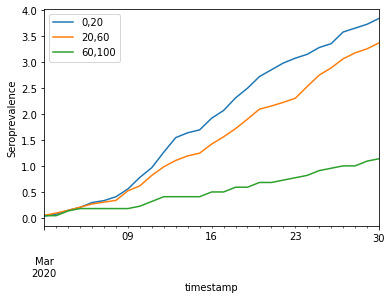

In [119]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.ylabel("Seroprevalence")
plt.legend()

## Care home deaths in hospital

In [120]:
care_home_deaths_hospital = deaths_df[
    (deaths_df['location_specs'] == 'hospital') 
    & (deaths_df['residence_type'] == 'care_home')
]
care_home_deaths_hospital=care_home_deaths_hospital.groupby(
    ['name_region', 'timestamp']
).size()

In [121]:
try:
    care_home_deaths_hospital.unstack(level=0).plot()
catch TypeError:
    print("this may fail if your simulation doesn't have care home deaths")

SyntaxError: invalid syntax (986496423.py, line 3)

## Where people get infected as a function of time

In [ ]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

In [ ]:
ax = locations_df.unstack(level=0).plot()
ax.legend(loc="center left", bbox_to_anchor=(1,0.5))

In [ ]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')


## Where people of certain age get infected as a function of time

In [ ]:
old_locations_df = infections_df[
    infections_df.age > 65
].groupby(['location_specs', 'timestamp']).size()

In [ ]:
old_locations_df.unstack(level=0).plot()

## How many households have everyone infected?

In [ ]:
n_infected_by_household = infections_df[
    infections_df['residence_type'] == 'household'
].groupby('residence_id').size()

In [ ]:
residence_id = []
n_residents = []
for household in world.households:
    residence_id.append(household.id)
    n_residents.append(household.n_residents)
household_people = pd.DataFrame({"residence_id":residence_id, "n_residents":n_residents})

In [ ]:
n_total_in_household = household_people[
    household_people['residence_id'].isin(
        n_infected_by_household.index
    )
]['n_residents']

In [ ]:
(n_infected_by_household/n_total_in_household).hist()
plt.xlabel('% of the household infected')

## Percentage of infected per care home

In [ ]:
n_infected_by_carehome = infections_df[
    infections_df['residence_type'] == 'care_home'
].groupby(
    'residence_id'
).size()

In [ ]:
n_total_in_carehome = people_df[
    (people_df['residence_type'] == 'care_home') 
    & (people_df['residence_id'].isin(n_infected_by_carehome.index))  
].groupby('residence_id').size()

In [ ]:
(n_infected_by_carehome/n_total_in_carehome).hist()
plt.xlabel('% of the care home infected')

In [ ]:
# from all care homes, how many got at least one case?

In [ ]:
n_total_care_homes = people_df[
    (people_df['residence_type'] == 'care_home') 
]['residence_id'].nunique()

In [ ]:
n_total_care_homes

In [ ]:
care_homes_with_infected = infections_df[
    (infections_df['residence_type'] == 'care_home') 
]['residence_id'].nunique()

In [ ]:
care_homes_with_infected/n_total_care_homes